Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?
3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)
4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) по смотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

In [3]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 8.2MB 7.4MB/s 


In [5]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp37-none-any.whl size=32917 sha256=eeb44db314bcbba2224940c681d24a8c36f8ae9e5b1d5f47d2f5d6f746ef872b
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import callbacks

from IPython import display

In [8]:
df = pd.read_excel('../content/drive/MyDrive/Colab_data/отзывы за лето.xls')
df.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20659 entries, 0 to 20658
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   20659 non-null  int64 
 1   Content  20656 non-null  object
 2   Date     20659 non-null  object
dtypes: int64(1), object(2)
memory usage: 484.3+ KB


In [10]:
MAX_WORDS = 200
MAX_LEN = 0
NUM_CLASSES = 5

# Train vars
EPOCHS = 10
BATCH_SIZE = 64
PRINT_BATCH_N = 100

In [11]:
sw = set(get_stop_words('ru'))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [12]:
def preprocess_text(txt):
    txt = str(txt)
    txt = ''.join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = " ".join(txt)
    return txt

In [13]:
df['Content'] = df['Content'].apply(preprocess_text)
df.head()

,Rating,Content,Date
0,5,it just works,2017-08-14
1,4,целое удобноной приложениеиз минус хотеть боль...,2017-08-14
2,5,отлично,2017-08-14
3,5,зависать 1 работа антивирус ранее пользоваться...,2017-08-14
4,5,удобно работать быстро,2017-08-14


In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
unique_words_count = np.unique(np.array([len(word_tokenize(text)) for text in df['Content']]))

MAX_LEN = unique_words_count.max()
Q25_LEN = round(np.quantile(unique_words_count, 0.25))
MEAN_LEN = round(unique_words_count.mean())
MEDIAN_LEN = round(np.median(unique_words_count))
Q75_LEN = round(np.quantile(unique_words_count, 0.75))
MIN_LEN = unique_words_count.min()

print(f'MAX: {MAX_LEN}' \
      f'\nQUANTILE_75: {Q75_LEN}' \
      f'\nMEAN: {MEAN_LEN}' \
      f'\nMEDIAN: {MEDIAN_LEN}' \
      f'\nQUANTILE_25: {Q25_LEN}' \
      f'\nMIN: {MIN_LEN}')

MAX: 132
QUANTILE_75: 55
MEAN: 40
MEDIAN: 36
QUANTILE_25: 18
MIN: 0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Rating'], test_size=0.3, shuffle=True)


In [19]:
train_corpus = " ".join(X_train)
train_corpus = train_corpus.lower()
train_corpus[:100]

'удобный приложение учиться тинькова господин пользуюсьот безисходка обновление последний возможно сд'

In [20]:
tokens = word_tokenize(train_corpus)

print(len(tokens))
print(tokens[:5])

70689
['удобный', 'приложение', 'учиться', 'тинькова', 'господин']


In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]

print(len(tokens_filtered))
print(tokens_filtered[:5])

70240
['удобный', 'приложение', 'учиться', 'тинькова', 'господин']


In [23]:
dist = FreqDist(tokens_filtered)
token_filtered_top = [pair[0] for pair in dist.most_common(MAX_WORDS-1)]
token_filtered_top[:5]

['приложение', 'удобно', 'работать', 'удобный', 'отлично']

In [24]:
vocabulary = {v: k for k, v in dict(enumerate(token_filtered_top, 1)).items()}


In [25]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    padding = padding + result[-maxlen:]
    return padding

In [26]:
X_train_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_train], dtype=np.int32)
X_test_bow = np.asarray([text_to_sequence(text, MAX_LEN) for text in X_test], dtype=np.int32)

print(X_train_bow)
print(X_train_bow.shape)

print(X_test_bow)
print(X_test_bow.shape)

[[ 0  0  0 ...  0  4  1]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 54 27  1]
 ...
 [ 0  0  0 ...  0  0  6]
 [ 0  0  0 ...  0  9  1]
 [ 0  0  0 ...  0  0  2]]
(14461, 132)
[[  0   0   0 ...  20 102  43]
 [  0   0   0 ...  20  72 119]
 [  0   0   0 ...   0   0  10]
 ...
 [  0   0   0 ...   0  12   2]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
(6198, 132)


In [27]:
y_train_cat = utils.to_categorical(y_train, num_classes=NUM_CLASSES+1)
y_test_cat = utils.to_categorical(y_test, num_classes=NUM_CLASSES+1)

print(y_train_cat[:5])
print(y_train_cat.shape)

print(y_test_cat[:5])
print(y_test_cat.shape)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
(14461, 6)
[[0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]]
(6198, 6)



1. Учим conv сеть для классификации

In [28]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 16s 73ms/step - loss: 1.3922 - accuracy: 0.4107 - val_loss: 0.7022 - val_accuracy: 0.7671
Epoch 2/10
204/204 [==============================] - 14s 71ms/step - loss: 0.7169 - accuracy: 0.7557 - val_loss: 0.6786 - val_accuracy: 0.7671
Epoch 3/10
97/97 [==============================] - 2s 19ms/step - loss: 0.6923 - accuracy: 0.7630
Test score: 0.6922624111175537
Test accuracy: 0.7629880309104919


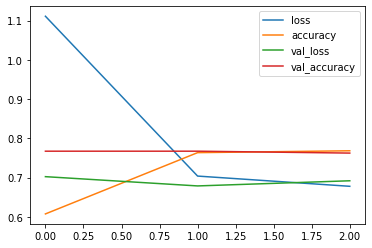

In [30]:
pd.DataFrame(history.history).plot()


97/97 [==============================] - 2s 19ms/step
       y_test  y_pred
idx                  
14637       3       1
18538       1       1
17663       5       5
12329       4       5
472         1       1
...       ...     ...
2806        5       5
10492       5       5
11225       5       5
12907       5       5
421         5       5

[6198 rows x 2 columns]


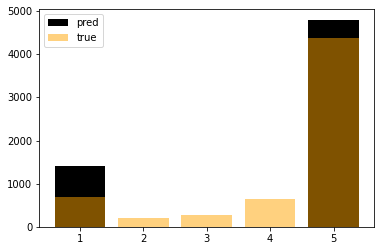

In [31]:
y_pred = model.predict(X_test_bow, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='black', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='orange', label='true')
plt.legend()
plt.show()

2. Берём предобученный word2vec и его эмбедингами инициализируем сетку, как влияет на качество?

In [32]:
import gensim.downloader as api
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [33]:
wv = api.load('glove-twitter-25')


[==================================================] 100.0% 104.8/104.8MB downloaded


In [34]:
def text_to_wv(text, maxlen):
    result = []
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum()]
    for w in words:
        if w in wv:
            result.append(list(wv[w]))
    padding = [[0]*25]*(maxlen-len(result))
    result = padding + result[-maxlen:]
    return result

In [35]:
X_train_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_train])
X_test_wv = np.array([text_to_wv(text, MAX_LEN) for text in X_test])

print(X_train_wv.shape)
print(X_test_wv.shape)

(14461, 132, 25)
(6198, 132, 25)


In [36]:
model = models.Sequential([
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    layers.Dense(10),
    layers.Activation('relu'),
    
    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_wv, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_wv, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
204/204 [==============================] - 5s 23ms/step - loss: 1.1934 - accuracy: 0.6063 - val_loss: 0.8125 - val_accuracy: 0.7125
Epoch 2/10
204/204 [==============================] - 4s 21ms/step - loss: 0.8146 - accuracy: 0.7143 - val_loss: 0.7477 - val_accuracy: 0.7346
Epoch 3/10
204/204 [==============================] - 4s 21ms/step - loss: 0.7634 - accuracy: 0.7298 - val_loss: 0.7276 - val_accuracy: 0.7554
Epoch 4/10
204/204 [==============================] - 4s 21ms/step - loss: 0.7407 - accuracy: 0.7420 - val_loss: 0.7223 - val_accuracy: 0.7630
Epoch 5/10
204/204 [==============================] - 4s 21ms/step - loss: 0.7078 - accuracy: 0.7538 - val_loss: 0.7002 - val_accuracy: 0.7408
Epoch 6/10
204/204 [==============================] - 4s 21ms/step - loss: 0.6765 - accuracy: 0.7666 - val_loss: 0.6868 - val_accuracy: 0.7630
Epoch 7/10
204/204 [==============================] - 4s 21ms/step - loss: 0.6677 - accuracy: 0.7694 - val_loss: 0.6827 - val_accuracy: 0.7664

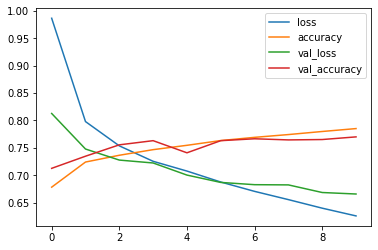

In [38]:
pd.DataFrame(history.history).plot()


97/97 [==============================] - 1s 6ms/step
       y_test  y_pred
idx                  
14637       3       4
18538       1       1
17663       5       5
12329       4       5
472         1       1
...       ...     ...
2806        5       5
10492       5       5
11225       5       5
12907       5       5
421         5       5

[6198 rows x 2 columns]


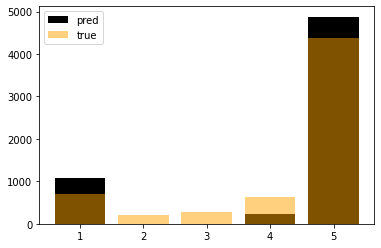

In [39]:
y_pred = model.predict(X_test_wv, batch_size=BATCH_SIZE, verbose=1)
y_pred = pd.Series(y_pred.argmax(axis=1))

result = pd.DataFrame({'idx': y_test.index, 'y_test': y_test.values, 'y_pred': y_pred.values}).set_index('idx')
print(result)

plt.bar(result['y_pred'].value_counts().index, result['y_pred'].value_counts().values, color='black', label='pred')
plt.bar(result['y_test'].value_counts().index, result['y_test'].value_counts().values, alpha=0.5, color='orange', label='true')
plt.legend()
plt.show()

3. Сравнить разные виды эмбедингов tf.Embeddings word2vec/Fasttext (в качестве агригации попробовать разные виды не только среднее для документа)

In [40]:
df_score = pd.DataFrame(columns=['aggr']).set_index('aggr')


In [41]:
for key, val in {'q25': Q25_LEN, 'mean': MEAN_LEN, 'median': MEDIAN_LEN, 'q75': Q75_LEN, 'max': MAX_LEN}.items():
    
    display.clear_output(wait=False)
    
    model = models.Sequential([
        layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=val),
        layers.Conv1D(filters=128, kernel_size=3),
        layers.Activation('relu'),

        layers.GlobalMaxPool1D(),
        layers.Dense(10),
        layers.Activation('relu'),

        layers.Dense(NUM_CLASSES+1),
        layers.Activation('softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
    early_stopping = callbacks.EarlyStopping(monitor='val_loss')

    history = model.fit(
        X_train_bow, y_train_cat, 
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_split=0.1,
        callbacks=[tensorboard, early_stopping]
    )

    score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

    df_score.loc['aggr', key] = score[1]

Epoch 1/10
204/204 [==============================] - 15s 72ms/step - loss: 1.1088 - accuracy: 0.6945 - val_loss: 0.6877 - val_accuracy: 0.7678
Epoch 2/10
97/97 [==============================] - 2s 19ms/step - loss: 0.6927 - accuracy: 0.7649


In [42]:
df_score


,q25,mean,median,q75,max
aggr,,,,,
aggr,0.769119,0.769603,0.770087,0.770087,0.764924


4. По моделировать различные архитектуры сетей (несколько слоёв свёрток с пулингом без с полносвязанными и без них) посмотреть какая архитектура быстрее переобучается, какая более хорошо решает текущую задачу

+1 Conv

Epoch 1/10
204/204 [==============================] - 37s 176ms/step - loss: 0.9591 - accuracy: 0.7097 - val_loss: 0.6827 - val_accuracy: 0.7664
Epoch 2/10
97/97 [==============================] - 4s 43ms/step - loss: 0.6886 - accuracy: 0.7615


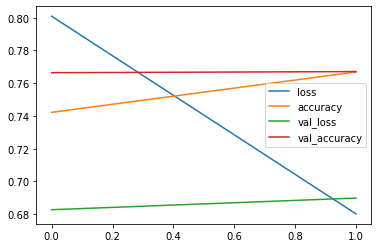

In [43]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Dense(10),
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()

-- Dense

Epoch 1/10
204/204 [==============================] - 37s 177ms/step - loss: 0.9750 - accuracy: 0.7134 - val_loss: 0.6874 - val_accuracy: 0.7623
Epoch 2/10
97/97 [==============================] - 4s 44ms/step - loss: 0.7035 - accuracy: 0.7619


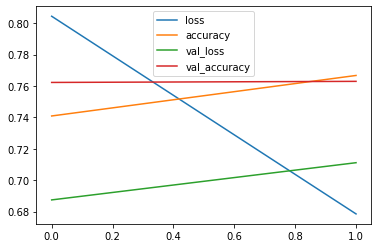

In [44]:
model = models.Sequential([
    layers.Embedding(input_dim=MAX_WORDS, output_dim=128, input_length=MAX_LEN),
    
    layers.Conv1D(filters=128, kernel_size=5),
    layers.Activation('relu'),
    
    layers.Conv1D(filters=128, kernel_size=3),
    layers.Activation('relu'),
    
    layers.GlobalMaxPool1D(),
    
    layers.Activation('relu'),

    layers.Dense(NUM_CLASSES+1),
    layers.Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

tensorboard = callbacks.TensorBoard(log_dir='./logs', write_graph=True, write_images=True)
early_stopping = callbacks.EarlyStopping(monitor='val_loss')

history = model.fit(
    X_train_bow, y_train_cat, 
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=[tensorboard, early_stopping]
)

score = model.evaluate(X_test_bow, y_test_cat, batch_size=BATCH_SIZE, verbose=1)

pd.DataFrame(history.history).plot()